# Distributional and frequency effects in word embeddings: Distributional effects and hubs
## © 2018 Chris Culy, June 2018
### [chrisculy.net](http://chrisculy.net/)

## Overview

This is one of a [series of posts](dist_freq_intro.html). In this post I examine the issue of "hubs": words/vectors that are very similar to many other words/vectors. While the existence of hubs is a mathematical property of (certain) vector spaces, I will explore them with regard to whether the hubs that arise in word embeddings have any patterns that are due either to language or to the methods used for creating the word embeddings. One particular result is that hubs show frequency effects; another is that ppmi is very different from the other 3 methods on the very small corpus, heartd.

### Results and contribution

* **new** word embeddings usually have hubs
    - the exception is with the very small corpus
    - the exception to the exception is that ppmi _does_ have hubs with the very small corpus
* **new** the hubs can vary (slightly) by run of a method
* **new** the hubs vary by method
* **new** the hubs show frequency effects
    - sgns and ft have mostly/only low frequency hubs
    - glove has mostly higher frequency hubs, with a spike at the very lowest frequencies
    - ppmi has hubs in a range of frequencies, with a spike at the very lowest frequencies
* **new** stratification of similarities is not sufficient to explain the hub frequency effects

[Download as Jupyter notebook](dist_freq_hubs.ipynb)

[Download supplemental Python code](dfewe.zip)

<input type="checkbox" id="toggleCheck" checked> Show Code

In [1]:
#imports
from dfewe import *

#for tables in Jupyter
from IPython.display import HTML, display
import tabulate

In [2]:
# some utilities
def show_title(t):
    display(HTML('<b>%s</b>' % t))

def show_table(data,headers,title):
    show_title(title)
    display(HTML(tabulate.tabulate(data,tablefmt='html', headers=headers)))

#for dynamic links
links = ('<a href="#link%d">Skip down</a>' % i for i in range(100))
anchors = ('<span id="link%d"></span>' % i for i in range(100))

def make_link():
    display(HTML(next(links)))

def make_anchor():
    display(HTML(next(anchors)))
    

In [3]:
#set up standard corpora + vectors
vfair_all = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
heartd_all = Setup.make_standard_sampler_and_vecs('heartd',5,100,1) #window=5, dims=100, min_count=1

what = [['Vanity Fair (vfair)'],['Heart of Darkness (heartd)']]
for i,c in enumerate([vfair_all,heartd_all]):
    sampler = c['sampler']
    what[i].extend([sum(sampler.counts.values()), len(sampler.counts)])

show_table(what, headers=['Corpus','Tokens','Types'], title="Corpora sizes")

## Background

The notion of hubs comes from work on k-nearest neighbor classification, and in fact "Hubness is a phenomenon related specifically to nearest-neighbor methods." [[1]](#ref1) Since nearest neighbors are an important aspect of the use of word vectors (for example in word similarity and analogy evaluations), it's reasonable to consider the properties of hubs in word embeddings. [[2]](#ref2) discuss hubs as a potential problem for evaluation and propose a mitigation strategy, which I will return to in a subsequent post (TBD).

The fundamental observation is that there are some vectors which are very similar more vectors than most vectors are. These vectors are the hubs. 

A key notion is that of $NN_{k}(x)$, which is the number of times vector x is one of the k-nearest neighbors of other data points. I'll extend that notion to make the word vectors explicit, and so we can explore the possibility of frequency effects.

<blockquote>
    $NN_{k}(x,Y)$, where x is a word vector and Y is a set of word vectors, is the number of times x is one of the k-nearest neighbors of a word vector in Y.
</blockquote>

Let's see what $NN_{k}$ looks like for some words. (Throughout this post I'll use k=1000; k=1 is small, k=100 is reasonable, and k>1000 doesn't really add anything.)

In [4]:
def nn_k_for_all(k,words,vecs):
    """
    find nn_k for using the whole vocabulary of vecs, using the similarity of vecs
    """

    others = vecs.vocab.keys()
    return Hubs.nn_k(vecs.similar_by_word,k,words,others)

def example1():
    vecs = vfair_all['sgns']
    words = ['carriage','cart','lady','lord','man','woman']
    
    headers = ['Word','NN<sub>1000</sub>']
    d = sorted(nn_k_for_all(1000,words,vecs), key=lambda x: x[0])
    
    show_table(d, headers, '')
    
example1()

We can see that _cart_ is one of the 1000-nearest neighbors for over 1000 other words while _man_ is one of the 1000-nearest neighbors of fewer than 10 words.

Hubs then are vectors that have a higher than typical $NN_{k}$, like _cart_ in this example.

Since "higher than typical" is a bit vague, it's worth looking at the distribution of the values of $NN_{k}$, and we'll do so by sampling words in percentile bands, and compare them to a sample from all of the vocabulary. (I'm doing the sampling rather than all the comparisons to save time.) Here's the results for the sgns vectors for vfair.

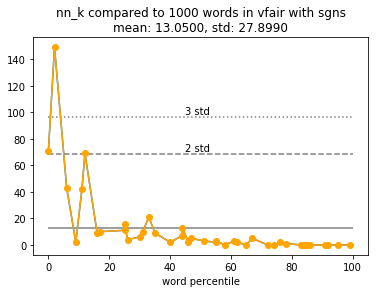

In [5]:
sampler = vfair_all['sampler']
vecs = vfair_all['sgns']
name = 'vfair with sgns'
Hubs.nn_k_by_percentile(sampler,vecs,name,k=1000,max_words=1000,steps=5,words_per_step=2)

The first thing to notice is that there are some words that clearly qualify as hubs. The second thing to notice is the extreme skewing of the distribution by percentile. 

Here's a comparison of all 4 methods for vfair. Notice the sampling makes a difference for $NN_k$ values for vfair compared to the above, but only a slight difference for hubs, and the overall trend is the same.

However the main observation to make is that once again, glove and ppmi have very different trends from vfair and ft, with more variation and less clear hubs.

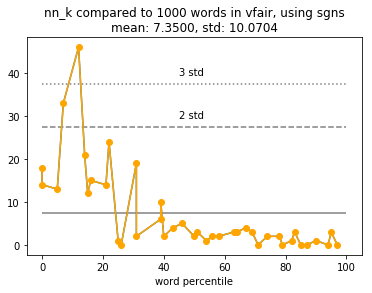

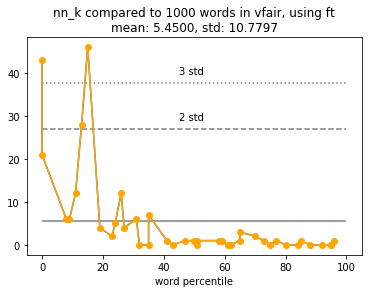

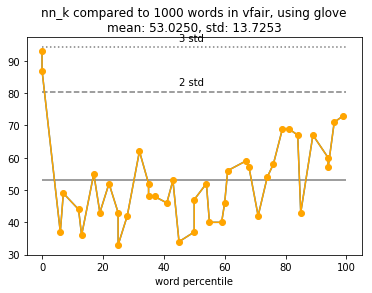

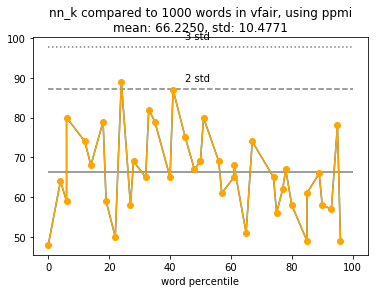

In [6]:
combo = vfair_all
name='vfair'
Hubs.compare_nn_k_by_percentile(combo,name,k=1000,max_words=1000,steps=5,words_per_step=2)

Now let's look at heartd. Unfortunately, it's hard to say much other than all 4 methods show different trends than with vfair. Sampling may well be the culprit here, so we'll look more carefully below.

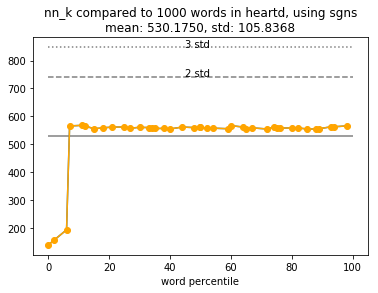

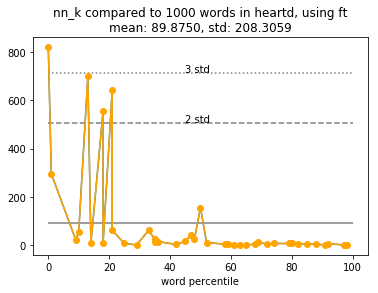

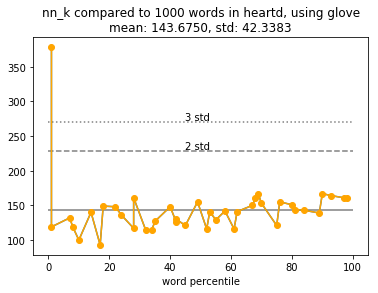

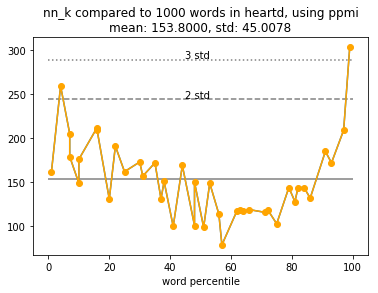

In [7]:
combo = heartd_all
name='heartd'
Hubs.compare_nn_k_by_percentile(combo,name,k=1000,max_words=1000,steps=5,words_per_step=2)

## Hub basics

We still need to operationalize the notion of hub. One thing that is immediately obvious from all of the graphs above is that $NN_k$ is not a normal distribution, whatever it is. However, can still use standard deviation as a _heuristic_ for finding hubs: we choose a threshold number of standard deviations and if the $NN_k$ is below that threshold, it does not count as a hub. We can then examine the words above the threshold and then either take them all or the highest scoring ones.

Here are the results for vfair, using 4 standard deviations as the threshold, and showing just the top 10 words.


In [8]:
def show_hubs(sampler,vecs,name,k=1000,threshold=4,topn=10):
    """
    show the hubs with at k_nn of at least threshold standard deviations above the mean. 
    if topn is True, show all of them (with that threshold)
    """
    (m,std,df) = Hubs.find_hubs_with_all(sampler,vecs,k=k,thresh=threshold)

    title = "Hubs for %s with k=%d and threshold of %d standard deviations" % (name,k,threshold)
    show_title(title)
    stitle = "Overall mean: %0.4f &nbsp;&nbsp; Overall std: %0.4f" % (m,std)
    show_title(stitle)
    display(HTML(df[:topn].to_html(index=False)))

def compare_hubs(combo,name,k=1000,threshold=4,topn=10):
    """
    do show_hubs for the different methods in combo
    """
    
    Utils.compare_methods(combo,name,show_hubs,k=k,threshold=threshold,topn=topn)

In [9]:
k = 1000
threshold = 4
topn = 10
compare_hubs(vfair_all,'vfair',k=k,threshold=threshold,topn=topn)

## Variability of hubs

### Variability by run

Various researchers, including [[2]](#ref2), [[3]](#ref3) any [my own earlier post](wvecs_random_fix.html), have found that word similarities vary across runs of algorithms like sgns due to their random aspects. Not surprisingly the same is true for hubs, since they are based on similarities.

As an example, here's a listing of the top 20 words for $NN_{1000}$ for vfair with the sgns vectors from three runs of sgns. While there are some differences, they are slight.


In [10]:
def compare_runs(topn=20):
    vfair_all2 = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
    vfair_all3 = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1

    (m1,std1,df1) = Hubs.find_hubs_with_all(vfair_all['sampler'],vfair_all['sgns'])
    (m2,std2,df2) = Hubs.find_hubs_with_all(vfair_all2['sampler'],vfair_all2['sgns'])
    (m3,std3,df3) = Hubs.find_hubs_with_all(vfair_all3['sampler'],vfair_all3['sgns'])

    title = 'Comparison of hubs across runs of sgns with vfair'
    what = '<table><tr><th>run 1</th><th>run 2</th><th>run 3</th></tr>'
    what += '<tr><td>' + df1[:topn].to_html(index=False) + '</td>'
    what += '<td>' + df2[:topn].to_html(index=False) + '</td>'
    what += '<td>' + df3[:topn].to_html(index=False) + '</td></tr></table>'

    show_title(title)
    display(HTML(what))

In [11]:
compare_runs(20)

### Variability by method

We can also compare the hubs across the different methods for vfair. What we find is that each method leads to different hubs.

In [12]:
def compare_hub_words(combo,name,k=1000,thresh=4,topn=20):
    """
    compare which words are hubs, among the topn
    """

    sampler = combo['sampler']
    
    vs = ['sgns','ft','glove','ppmi']
    vhubs = dict()

    for v in vs:
        vecs = combo[v]
        (m,std,df) = Hubs.find_hubs_with_all(sampler,vecs,k=k,thresh=threshold)
        if v == 'glove':
            df = df.replace('<unk>', '&lt;unk&gt;') #rename <unk> so it appears in html
        vhubs[v] = set(list(df[:topn]['word']))
        
    show_title("Comparison of top %d hubs for %s, k=%d, threshold=%d stds" % (topn,name,k,thresh))

    maxn = 0
    in_all = set()
    in_some = set()
    for h in vhubs.values():
        in_some |= h
        in_all &= h
        maxn = max(maxn,len(h))
        
    combon = len(in_all)
    
    
    show_title('Distinct hubs: %d Combined overlap: %d' % (len(in_some), combon))
    
    if combon == 0:
        display(HTML('<em>There are no hubs in common among the top %d hubs for each method</em>' % maxn))    
    else:
        if combon == maxn:
            display(HTML('<em>There is complete overlap among the top %d hubs for each method</em>' % maxn))    
        display(HTML('<p>' + '<br>'.join(sorted(list(in_all))) + '</p>'))
            
    if combon < maxn:
        #pairwise comparison
        for v1 in vhubs:
            for v2 in vhubs:
                if v1==v2:
                    break

                what = []
                
                overlap = vhubs[v1] & vhubs[v2]
                first_not_second = vhubs[v1] - vhubs[v2]
                second_not_first = vhubs[v2] - vhubs[v1]
                what += [[', '.join(sorted(list(overlap))),
                         ', '.join(sorted(list(first_not_second))),
                         ', '.join(sorted(list(second_not_first)))]]

                headers = ["%s and %s overlap: %d" % (v1,v2, len(overlap)),
                            "%s but not %s: %d" % (v1,v2, len(first_not_second)),
                            "%s but not %s: %d" % (v2,v1, len(second_not_first))]

                show_table(what,headers,'')

In [13]:
k = 1000
threshold = 4
topn = 50
make_link()
compare_hub_words(vfair_all,'vfair', k=k,thresh=threshold,topn=topn)
make_anchor()

Repeating the same comparison with heartd (but using 3 standard deviations as our threshold), we again find very different hubs across the methods.

In [14]:
k = 1000
threshold = 3 #NB 3 instead of 4
topn = 50
make_link()
compare_hub_words(heartd_all,'heartd', k=k,thresh=threshold,topn=topn)
make_anchor()

### Variability by frequency

We can also examine the role of word frequency for hubs. One aspect is to see if different frequency bands have different hubs. In fact, they do, with some hubs overlapping across the different frequency bands. Here's what that looks like for vfair.

In [15]:
def show_hubs_for_band(sampler,vecs,name,k=1000,threshold=2,step=5,topn=20,show_full=True):
    """
    use each band of width step of the vocabulary as others; use whole vocab as potentilas
    i.e. this looks for hubs that are _for_ the bands
    """
    
    what = Hubs.find_hubs_for_band(sampler,vecs,k=k,thresh=threshold,step=5)
    
    counts = Counter()
    same_bands = 0
    num_hubs = 0
    for i,(m,std,df_) in enumerate(what):
        df = df_[:topn].copy()
        counts.update(list(df['word']))
        df['same band'] = (df['percentile'] >= i) & (df['percentile'] <= i+step)
        same_bands += len(df[df['same band']])
        num_hubs += len(df)
        if show_full: 
            lname = "%s, hubs for range percentiles %d to %d" %(name, i,i+step)
            title = "Hubs for %s with k=%d and threshold of %d standard deviations" % (lname,k,threshold)
            show_title(title)
            stitle = "Overall mean: %0.4f &nbsp;&nbsp; Overall std: %0.4f" % (m,std)
            show_title(stitle)
            if len(df[df['word'] == '<unk>']) > 0:
                df = df.replace('<unk>', '&lt;unk&gt;') #rename <unk> so it appears in html (for glove)
            display(HTML(df.to_html(index=False)))

            
    if num_hubs > 0:
        d = [[w,sampler.get_percentile(w),c] for (w,c) in counts.most_common()]
        show_table(d,['Hub','Percentile','Number of bands'], 'Hubs and the number of bands they occured in for %s' % name)
        
        show_title('Distribution of hubs by percentile for %s' %name)
        pcounts = Counter()
        for (_,p,c) in d:
            pcounts.update({p:c})
        pdata = [pcounts[i] if i in pcounts else 0 for i in range(0,101)]
        
        fig, ax = plt.subplots(figsize=(10, 2))
        
        ax.bar(np.arange(0,101), pdata, color='orange')
        ax.set_xticks(np.arange(0,101,10))
        ax.set_xlabel('percentile')
        ax.set_ylabel('count')
       

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        plt.show()
    
        show_title('Across the bands, %d of %d (= %0.2f) from among the %d hubs in each were in the target band' % 
               (same_bands, num_hubs, same_bands/num_hubs, topn))
    else:
        show_title('There are no hubs in any of the bands in %s at threshold = %0.2f' % (name, threshold))
    
def compare_hubs_for_band(combo,name,k=1000,threshold=2,step=5,topn=20,show_full=False):
    """
    do show_hubs_for_band for each method in combo
    """
    
    Utils.compare_methods(combo,name,show_hubs_for_band,k=k,threshold=threshold,step=step,topn=topn,show_full=show_full)

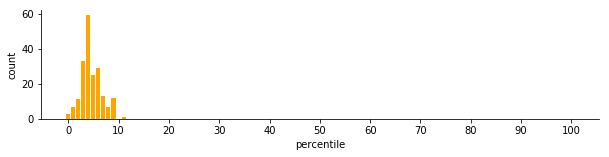

In [16]:
name = 'vfair, with sgns'
sampler = vfair_all['sampler']
vecs = vfair_all['sgns']
k = 1000
thresh = 4
step = 5
topn = 10
make_link()
show_hubs_for_band(sampler,vecs,name,k=k,threshold=thresh,step=step,topn=topn, show_full=False)
make_anchor()

The obvious thing to notice is that the hubs are mostly relatively _low_ frequency words (10th percentile or lower). As an additional consequence, only about 1/3 of the hubs were in the band being compared.

We can compare sgns with the other methods for vfair.

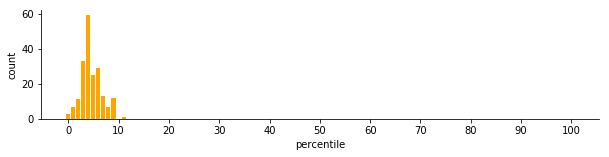

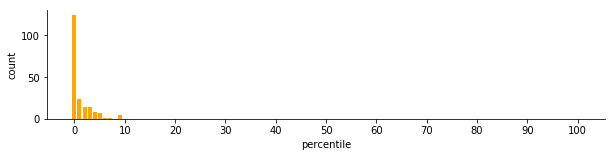

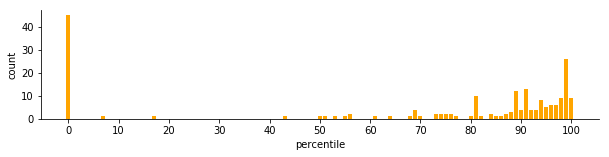

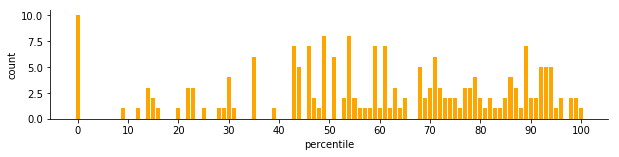

In [17]:
name = 'vfair'
combo = vfair_all
k = 1000
threshold = 4
step = 5
topn = 10
make_link()
compare_hubs_for_band(combo,name,k=k,threshold=threshold,step=step,topn=topn, show_full=False)
make_anchor()

There are a couple striking differences across the methods. The first is that sgns and ft show similar patterns, with hubs being primarily relatively low frequency words. glove and ppmi have spikes at the lowest frequency words, but the rest of the hubs in glove are spread out among the higher frequency words, while with ppmi the hubs occur more or less across the spectrum.

The other difference is the proportion of hubs occuring in the band being compared, from 0.31 for sgns to 0.12 for ft, down to 0.06 and 0.05 for glove and ppmi respectively.

We can check to see if the same patterns hold for heartd. They don't &mdash; rather there's a massive breakdown, except for ppmi. There are **no** hubs for sgns and ft, and only 1 for glove.

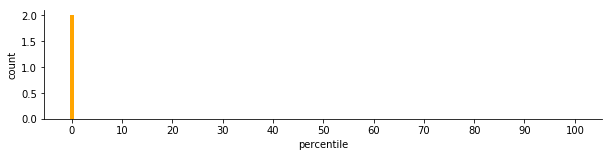

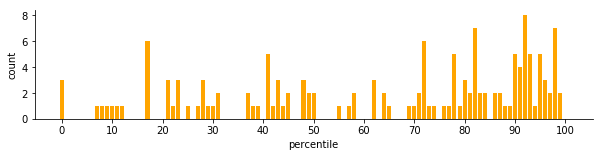

In [18]:
name = 'heartd'
combo = heartd_all
k = 1000
threshold = 3
step = 5
topn = 10
make_link()
compare_hubs_for_band(combo,name,k=k,threshold=threshold,step=step,topn=topn, show_full=False)
make_anchor()

## Discussion

It seems like there _should_ be a connection between the frequency effects with hubs and other frequency effects we've seen. However, the connection isn't straightforward, especially for heartd.

We saw in the [stratification post](dist_freq_stratification.html) that:

* for sgns and ft, frequency is _inversely_ related to similarity
* for glove and ppmi frequency is _directly_ related to similarity
    
Starting with sgns and ft, two low frequency words are _more_ similar than two high frequency words. Since there are lots of low frequency words, that might explain why we get the hubs in the lower frequency words. Glove works the opposite: two high frequency words are _more_ similar than two low frequency words, and we get high frequency hubs. The spike in hubs at the lowest frequencies corresponds to the [anomalous cell](dist_freq_stratification.html#vfair_strat1) in the stratification, where the lowest frequency words are more similar to each other than even slightly more frequent words. 

Nice so far. Unfortunately, ppmi doesn't follow the pattern. It shows similar stratification to glove, but its hubs, as we saw, are across the board. 

Heartd also only partially follows the pattern. sgns and ft are both _extremely_ stratified, which might explain why there are no hubs: _everything_ is close to everything else. However, glove and ppmi are more like vfair for stratification, but glove has only 1 hub in heartd, while ppmi has many.

Thus, even though the stratification of similarities _may_ be relevant for understanding hubs, it is clearly not sufficient.


[Back to the introduction](dist_freq_intro.html)


## The posts

* [Shifted similarity distributions](dist_freq_sim_shift.html)
* [Similarity stratification](dist_freq_stratification.html)
* [Frequency effects of vectors](dist_freq_vecs.html)
* [Strange geometry](dist_freq_geometry.html)
* ➤ Distributional effects and hubs
* [Recapitulation and next steps](dist_freq_recapit.html)

## References

<span id="ref1">[1]</span> Nenad Tomašev, Milos Radovanovic, Dunja Mladenić, and Mirjana Ivanovic. 2011. A probabilistic approach to nearest-neighbor classification: Naive hubness Bayesian kNN. Proceedings of the International Conference on Information and Knowledge Management. 2173-2176.

<span id="ref2">[2]</span> Johannes Hellrich and Udo Hahn. 2016. Bad Company—Neighborhoods in Neural Embedding Spaces Considered Harmful. In Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers, pp. 2785–2796, Osaka, Japan, December 11-17 2016.

<span id="ref3">[3]</span> Maria Antoniak and David Mimno. 2018. Evaluating the Stability of Embedding-based Word Similarities. In Transactions of the Association for Computational Linguistics, vol. 6, pp. 107–119.
